# Import Python libraries

In [2]:

import pandas as pd
import numpy as np
import seaborn as sns

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

import matplotlib.pyplot as plt
%matplotlib inline

import itertools

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

# Globals

In [3]:
RANDOM_STATE = 1
CLASS_NAMES = ['Benign', 'Malignant']
FEATUE_NAMES = []
N_FEATURES_TO_SELECT = 4

# Load data

In [4]:
#Read data
data = pd.read_csv('dataR2.csv')
data['Classification'] = data['Classification'].map({1:'Benign',2:'Malignant'})

FEATUE_NAMES = data.columns.tolist()[:-1]

print("num missing cells:",data.isnull().sum().sum())
data

num missing cells: 0


,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,Benign
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,Benign
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,Benign
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,Benign
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,Benign
...,...,...,...,...,...,...,...,...,...,...
111,45,26.850000,92,3.330,0.755688,54.6800,12.100000,10.96000,268.230,Malignant
112,62,26.840000,100,4.530,1.117400,12.4500,21.420000,7.32000,330.160,Malignant
113,65,32.050000,97,5.730,1.370998,61.4800,22.540000,10.33000,314.050,Malignant
114,72,25.590000,82,2.820,0.570392,24.9600,33.750000,3.27000,392.460,Malignant


- we confirmed that there are no missing values in any of the columns provided

# Exploratory Data Analysis (EDA)

## How data looks

In [794]:
data.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,Benign
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,Benign
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,Benign
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,Benign
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,Benign


In [795]:
# describe
data.describe().iloc[1:]#.to_csv('data_description.csv')

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
mean,57.301724,27.582111,97.793103,10.012086,2.694988,26.615080,10.180874,14.725966,534.647000
std,16.112766,5.020136,22.525162,10.067768,3.642043,19.183294,6.843341,12.390646,345.912663
min,24.000000,18.370000,60.000000,2.432000,0.467409,4.311000,1.656020,3.210000,45.843000
25%,45.000000,22.973205,85.750000,4.359250,0.917966,12.313675,5.474283,6.881763,269.978250
50%,56.000000,27.662416,92.000000,5.924500,1.380939,20.271000,8.352692,10.827740,471.322500
75%,71.000000,31.241442,102.000000,11.189250,2.857787,37.378300,11.815970,17.755207,700.085000
max,89.000000,38.578759,201.000000,58.460000,25.050342,90.280000,38.040000,82.100000,1698.440000


## Target variable
- preprocessing
- distirbutino/count plots
- split

In [796]:

data['Classification'].value_counts()

Malignant    64
Benign       52
Name: Classification, dtype: int64

### Split target

In [797]:
# 2 datasets
M = data[(data['Classification'] == 'Malignant')]
B = data[(data['Classification'] == 'Benign')]


In [798]:
###---------COUNT-----------------------
trace = go.Bar(x = (len(M), len(B)), y = ['malignant', 'benign'], orientation = 'h', opacity = 0.8, 
               marker=dict(color=[ 'gold', 'lightskyblue'],line=dict(color='#000000',width=1.5))
              )

layout = dict(title =  'Count of Classification variables', 
                font=dict(
                    family="Arial",
                    size=30,),
                    title_x=0.5)
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

#---------PERCENTAGE-------------------
trace = go.Pie(labels = ['malignant','benign'], values = data['Classification'].value_counts(), 
               textfont=dict(size=24), opacity = 0.9,
               marker=dict(colors=['gold','lightskyblue'], 
                           line=dict(color='#000000', width=1.5)))

layout = dict(title =  'Distribution of Classification variable',
                font=dict(
                    family="Arial",
                    size=30,),
                    title_x=0.5# 2 datasets
# M = data[(data['Classification'] == 'Malignant')]
# B = data[(data['Classification'] == 'Benign')]

    )
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)


## Features distribution (hue = Classification)

In [799]:
def plot_distribution(data_select, size_bin) :      
    hist_data = [M[data_select], B[data_select]]
    
    group_labels = ['malignant', 'benign']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, 
        colors = colors, show_hist = True, 
        bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select,
    font=dict(
        family="Arial",
        size=30,)
    )

    py.iplot(fig, filename = 'Density plot')

In [800]:
plot_distribution('Age', .5)

In [801]:
plot_distribution('BMI', .5)

In [802]:
plot_distribution('Glucose', 2.5)

In [803]:
plot_distribution('Insulin', 1)

In [804]:
plot_distribution('Leptin', .5)

In [805]:
plot_distribution('Adiponectin', .5)

In [806]:
plot_distribution('HOMA', .5)

## Correlation matrix

<AxesSubplot:>

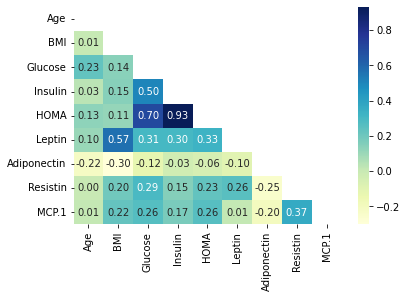

In [19]:
pd.set_option("display.precision", 2)

sns.heatmap(
    data.corr(), cmap="YlGnBu",
    fmt='.2f' 
    ,annot=True, mask=np.triu(np.ones_like(data.corr()))
)

In [808]:
def plot_feat1_feat2(feat1, feat2, filename=None) :  
    trace0 = go.Scatter(
        x = M[feat1],
        y = M[feat2],
        name = 'malignant',
        mode = 'markers', 
        marker = dict(color = '#FFD700',
            line = dict(
                width = 2
                ),
            size=12)
    )
    trace1 = go.Scatter(
        x = B[feat1],
        y = B[feat2],
        name = 'benign',
        mode = 'markers',
        marker = dict(color = '#7EC0EE',
            line = dict(
                width = 1),
            size=12))
    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
                  xaxis = dict(title = feat1, zeroline = False),
                  font=dict(
                        family="Arial",
                        size=22,),
                 )
    plots = [trace0, trace1]
    fig = dict(data = plots, layout=layout)

    py.iplot(fig)

In [809]:
plot_feat1_feat2('HOMA','Insulin',filename='homa_vs_insulin_correlation.png')
plot_feat1_feat2('Glucose','HOMA',filename='glucose_vs_homa_correlation.png')
plot_feat1_feat2('Age','BMI', filename='age_vs_bmi_correlation.png')

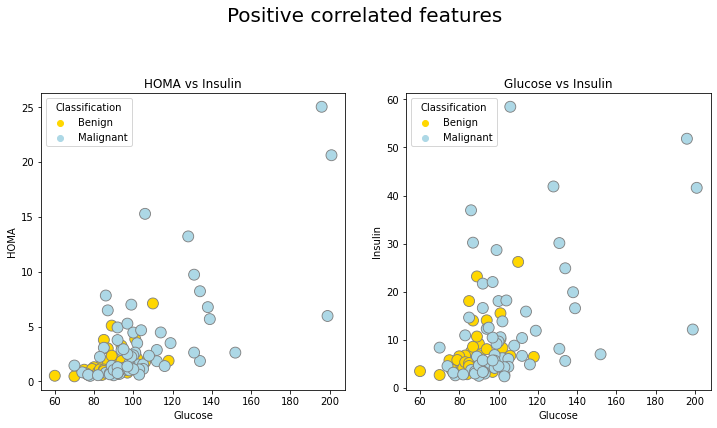

In [810]:
#Seaborn version :
palette ={'Malignant' : 'lightblue', 'Benign' : 'gold'}
edgecolor = 'grey'

# Plot +
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['Glucose'], y = data['HOMA'], hue = "Classification",
                    data = data, palette = palette, edgecolor=edgecolor, s=120)
plt.title('HOMA vs Insulin')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['Glucose'], y = data['Insulin'], hue = "Classification",
                    data = data, palette =palette, edgecolor=edgecolor,s=120)
plt.title('Glucose vs Insulin')

fig.suptitle('Positive correlated features', fontsize = 20)
plt.savefig('1')
plt.show()


# Uncorrelated features

In [811]:
plot_feat1_feat2('Adiponectin','Insulin', filename='adiponectin_vs_insulin_correlation.png')
plot_feat1_feat2('Leptin','MCP.1', filename='leptin_vs_mcp.1_correlation.png')

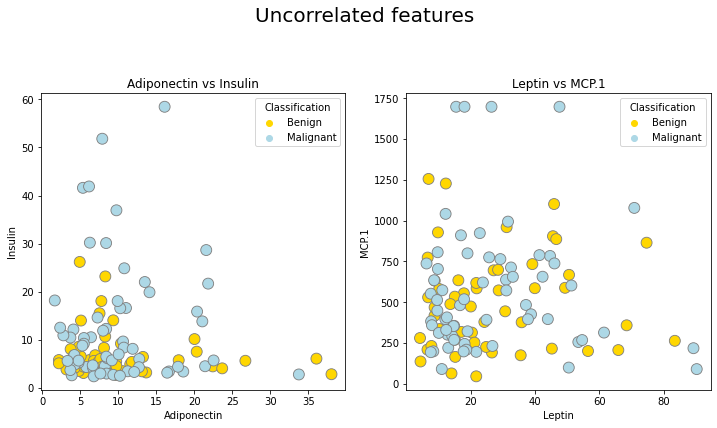

In [812]:
# seaborn version : 
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['Adiponectin'], y = data['Insulin'], hue = "Classification",
                    data = data, palette =palette, edgecolor=edgecolor, s=120)
plt.title('Adiponectin vs Insulin')
plt.subplot(222)
ax1 = sns.scatterplot(x = data['Leptin'], y = data['MCP.1'], hue = "Classification",
                    data = data, palette =palette, edgecolor=edgecolor, s=120)
plt.title('Leptin vs MCP.1')


fig.suptitle('Uncorrelated features', fontsize = 20)
plt.savefig('2')
plt.show()

# Example negative correlated features

In [813]:
plot_feat1_feat2('Adiponectin','BMI', filename='adiponectin_vs_bmi_correlation.png')
plot_feat1_feat2('Adiponectin','Resistin', filename='adiponectin_vs_resistin_correlation.png')

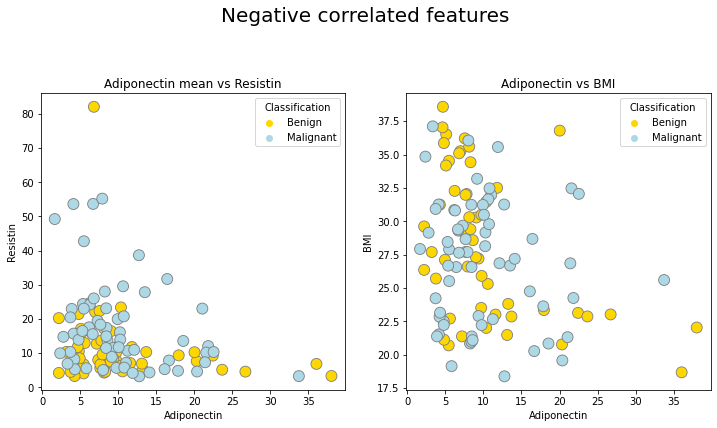

In [814]:
# seaborn version
fig = plt.figure(figsize=(12,12))

plt.subplot(221)
ax1 = sns.scatterplot(x = data['Adiponectin'], y = data['Resistin'], hue = "Classification",
                    data = data, palette =palette, edgecolor=edgecolor, s=120)
plt.title('Adiponectin mean vs Resistin')
plt.subplot(222)
ax2 = sns.scatterplot(x = data['Adiponectin'], y = data['BMI'], hue = "Classification",
                    data = data, palette =palette, edgecolor=edgecolor, s=120)
plt.title('Adiponectin vs BMI')
fig.suptitle('Negative correlated features', fontsize = 20)
plt.savefig('3')
plt.show()

## Principal Component Analysis
### Compute PCA

In [815]:
target_pca = data['Classification']
data_pca = data.drop('Classification', axis=1)

target_pca = pd.DataFrame(target_pca)

#To make a PCA, data normalization is essential
X_pca = data_pca.values
X_std = StandardScaler().fit_transform(X_pca)

pca = PCA(svd_solver='full') 
pca_std = pca.fit(X_std).transform(X_std)

pca_std = pd.DataFrame(pca_std)
pca_std.columns = pca_std.columns.map(lambda x: f'PC{x}')

pca_std

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-1.992785,0.125612,0.362869,0.274120,-0.492652,0.344671,-0.278678,-0.199885,0.250020
1,-1.328830,0.247930,1.336740,-1.894392,-0.175358,-0.085983,-0.084350,-0.440901,-0.018887
2,-1.217244,0.992393,0.363065,-0.913672,1.314762,-1.387647,-0.547082,0.156794,-0.044341
3,-1.199203,-0.272409,1.759583,-0.271717,-0.162707,-0.501004,-0.650166,-0.739578,0.048572
4,-0.898467,-0.143089,2.019185,-1.579261,-0.033842,-0.449444,-0.350436,-0.449584,-0.070410
...,...,...,...,...,...,...,...,...,...
111,-0.651096,-0.334463,-1.482829,0.230806,0.542825,0.348692,0.385412,-0.989853,0.061909
112,-1.267058,0.971953,-0.318653,-0.193755,0.722960,-0.810906,0.322608,0.784533,0.020117
113,-0.064035,-0.098318,-2.247799,-0.296319,1.433070,-1.134411,-0.054456,-0.087417,0.003668
114,-1.898629,1.562120,-1.071730,-0.205268,1.779002,-2.082930,-0.600808,0.495882,0.105642


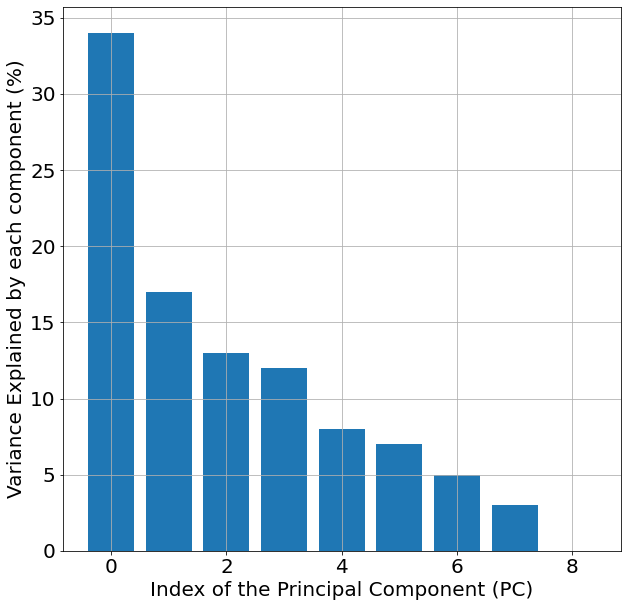

In [816]:
#explained_variance 
var_pca = pd.DataFrame(pca.explained_variance_ratio_).T

plt.figure(figsize=(10,10))
per_var=np.round(100*var_pca.values[0])
plt.bar(np.arange(len(per_var)),per_var)
var_pca = var_pca.T
plt.grid(True)
plt.xlabel("Index of the Principal Component (PC)", fontsize=20)
plt.ylabel('Variance Explained by each component (%)', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.show()



### scatter plot

In [817]:
def plot_pc_distribution(PCs,pca_index, data, size_bin=.05) :  
    tmp1 = PCs[data.Classification=='Malignant'][pca_index]
    tmp2 = PCs[data.Classification=='Benign'][pca_index]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['malignant', 'benign']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, 
        colors = colors, show_hist = True, 
        bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = f'PC #{pca_index}',font=dict(
                    family="Arial",
                    size=30,))

    py.iplot(fig, filename = 'Density plot')
    
    

In [818]:
pc_0 = plot_pc_distribution(pca_std,pca_index='PC0', data=data, size_bin=.2) 

In [819]:
pc_1 = plot_pc_distribution(pca_std,pca_index='PC1', data=data, size_bin=.2) 

In [820]:
pc_2 = plot_pc_distribution(pca_std,pca_index='PC2', data=data, size_bin=.2) 

In [821]:
pca_std['target'] = data['Classification']
pca_std

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,target
0,-1.992785,0.125612,0.362869,0.274120,-0.492652,0.344671,-0.278678,-0.199885,0.250020,Benign
1,-1.328830,0.247930,1.336740,-1.894392,-0.175358,-0.085983,-0.084350,-0.440901,-0.018887,Benign
2,-1.217244,0.992393,0.363065,-0.913672,1.314762,-1.387647,-0.547082,0.156794,-0.044341,Benign
3,-1.199203,-0.272409,1.759583,-0.271717,-0.162707,-0.501004,-0.650166,-0.739578,0.048572,Benign
4,-0.898467,-0.143089,2.019185,-1.579261,-0.033842,-0.449444,-0.350436,-0.449584,-0.070410,Benign
...,...,...,...,...,...,...,...,...,...,...
111,-0.651096,-0.334463,-1.482829,0.230806,0.542825,0.348692,0.385412,-0.989853,0.061909,Malignant
112,-1.267058,0.971953,-0.318653,-0.193755,0.722960,-0.810906,0.322608,0.784533,0.020117,Malignant
113,-0.064035,-0.098318,-2.247799,-0.296319,1.433070,-1.134411,-0.054456,-0.087417,0.003668,Malignant
114,-1.898629,1.562120,-1.071730,-0.205268,1.779002,-2.082930,-0.600808,0.495882,0.105642,Malignant


In [822]:
import plotly.express as px

fig = px.scatter_3d(pca_std, x='PC0', y='PC1', z='PC2',  color='target', size_max=10)
fig.show()

### Scatterplotm

In [823]:
# Positive correlated features
from copy import deepcopy
def plot_feat1_feat2_pca(PCs_with_target,feat1, feat2, filename=None) :  
    trace0 = go.Scatter(
        x = PCs_with_target[PCs_with_target.Classification=='Malignant'][feat1],
        y = PCs_with_target[PCs_with_target.Classification=='Malignant'][feat2],
        name = 'malignant',
        mode = 'markers', 
        marker = dict(color = '#FFD700',
            line = dict(
                width = 2
                ),
            size=12)
    )
    trace1 = go.Scatter(
        x = PCs_with_target[PCs_with_target.Classification=='Benign'][feat1],
        y = PCs_with_target[PCs_with_target.Classification=='Benign'][feat2],
        name = 'benign',
        mode = 'markers',
        marker = dict(color = '#7EC0EE',
            line = dict(width = 1),
            size=12))
    layout = dict(title = f'representation with 2 prominant (PC)s',
                  yaxis = dict(title = f'PC {feat2}',zeroline = False),
                  xaxis = dict(title = f'PC {feat1}', zeroline = False),
                  font=dict(
                        family="Arial",
                        size=22,),
                 )
    plots = [trace0, trace1]
    fig = dict(data = plots, layout=layout)
    
    if filename:
        myfig = go.Figure()
        myfig.add_traces(trace0)
        myfig.add_traces(trace1)
        myfig.write_image(filename)

    py.iplot(fig)

PCs_with_target = deepcopy(pca_std)
PCs_with_target.insert(PCs_with_target.shape[1],'Classification', data.Classification)
#plot_feat1_feat2_pca(PCs_with_target,feat1=0, feat2=1, filename=None) 

In [824]:
# To see the top 4 most important features
pca_components = abs(pca.components_)
print('Top 4 most important features in each component')
print('===============================================')
for row in range(pca_components.shape[0]):
    # get the indices of the top 4 values in each row
    temp = np.argpartition(-(pca_components[row]), 4)
    
    # sort the indices in descending order
    indices = temp[np.argsort((-pca_components[row])[temp])][:4]
    
    # print the top 4 feature names
    print(f'Component {row}: {data.columns[indices].to_list()}')

Top 4 most important features in each component
Component 0: ['HOMA', 'Insulin', 'Glucose', 'Leptin']
Component 1: ['BMI', 'Adiponectin', 'Insulin', 'HOMA']
Component 2: ['Leptin', 'MCP.1', 'BMI', 'Resistin']
Component 3: ['Age', 'MCP.1', 'Resistin', 'Adiponectin']
Component 4: ['Resistin', 'Adiponectin', 'Insulin', 'Leptin']
Component 5: ['MCP.1', 'Adiponectin', 'Resistin', 'Age']
Component 6: ['Glucose', 'Insulin', 'Age', 'Resistin']
Component 7: ['Leptin', 'BMI', 'MCP.1', 'Resistin']
Component 8: ['HOMA', 'Insulin', 'Glucose', 'BMI']


# EXPERIMENTAL Setting
- Define Performance Metrics
- This part is essential to measure the performance of a model : roc, cross validation, learning curve ...

## Data Prep

In [5]:
# Define X and Y
y = np.array(data.Classification.replace({'Malignant':1,'Benign':0}).tolist())

# Normalization
X_unnormalized = data.drop('Classification', 1).values
X = StandardScaler().fit_transform(X_unnormalized)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
 random_state = RANDOM_STATE)

print(np.unique(y_test, return_counts=True))
print(np.unique(y_train, return_counts=True))

(array([0, 1]), array([ 6, 18]))
(array([0, 1]), array([46, 46]))


/tmp/ipykernel_69511/19573525.py:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



## Metrics
- Confusion matrix 
- accuracy/precision/recall/f1score

In [8]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title,fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 fontsize=40,
                 color = 'white' if cm[i, j] > thresh else 'black')

    # plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

In [9]:
def get_metrics(cm):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    acc = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1_score = 2*(precision*rec)/(precision+rec)
    
    metrics = {'accuracy':acc,'precision':precision,
    'recall':rec,'f1score':f1_score}
    return metrics


In [10]:
# Precision – Recall curve
def plot_precision_recall(metric):
    plt.figure()
    recall = metric.iloc[0]['recall']
    precision = metric.iloc[0]['precision']
    
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.title('Precision Recall Curve', fontsize=20)
    plt.show();

In [11]:
# ROC curve
def plot_roc(fpr, tpr, title):
    plt.figure()
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 4)
    plt.plot([0,1],[0,1], 'k--', linewidth = 4,)
    # plt.xlim([0.0, 0.001])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=25)
    plt.xticks(fontsize = 20)CV_log_clf.best_params_
    plt.ylabel('True Positive Rate', fontsize=25)
    plt.yticks(fontsize = 20)
    plt.title(title, fontsize=28)
    plt.show();


markers = [  "v", ".", "*" ]
# ROC curve
def plot_roc_comparison(args, title):
    plt.figure()

    for i, (fpr, tpr, classifier_name) in enumerate(args):
        plt.plot(fpr, tpr, label = classifier_name, linewidth = 4, 
        marker=markers[i], alpha=.5, markersize=8
        )
    
    plt.plot([0,1],[0,1], 'k--', linewidth = 4,)        
    plt.xlabel('False Positive Rate', fontsize=25)
    plt.xticks(fontsize = 20)
    plt.ylabel('True Positive Rate', fontsize=25)
    plt.yticks(fontsize = 20)
    plt.title(title, fontsize=28)
    plt.legend()
    plt.grid(True)
    plt.show();


### Learning Curve

In [12]:
# Learning curve
def plot_learning_curve(estimator, title, X=X, y=y, 
ylim=(0.25,1.05), cv=10, figsize=(5,4),
n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
 

    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure(figsize=figsize)
    plt.title(title,fontsize=20)
    if ylim is not None:
        plt.ylim(*ylim)
    #plt.xlim([10,110])
    plt.xlabel('Training examples', fontsize=18)
    plt.xticks(fontsize = 13)
    plt.ylabel('Score', fontsize=18)
    plt.yticks(fontsize = 13)
   
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
  
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    
    plt.grid(True, linewidth=2)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score", linewidth=2)
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score", linewidth=2)
    plt.legend(loc = "best")
    plt.show();

# Experiment
- off the shelf performance
- performance with feature selection

In [14]:
performance = {} # classifier:performance
performance_with_rfe = {}
rfe_stats = {} # classifier:[selected features]
roc_data = [] #(fpr, tpr, classifier_name)

results = []

## Logistic Regression(1)
- find the best hyper partameters using cross validation
- fit the logreg model  

### Default

{'accuracy': 0.7083333333333334,
 'precision': 0.9230769230769231,
 'recall': 0.6666666666666666,
 'f1score': 0.7741935483870968,
 'classifier': 'LogReg',
 'scenario': 'default'}

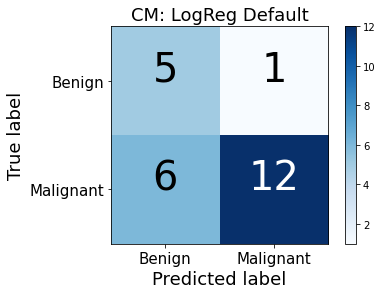

In [15]:

log_clf_default = LogisticRegression(
    random_state=RANDOM_STATE
)

log_clf_default.fit(X_train, y_train)
y_pred = log_clf_default.predict(X_test)

cm = confusion_matrix(y_test, y_pred)


plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: LogReg Default')

#y_score = log_clf.decision_function(X_test)
y_score = log_clf_default.predict_proba(X_test)[:,1]

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
roc_data.append((fpr, tpr, 'ROC: LogReg Default'))


m = get_metrics(cm)
m['classifier'] = 'LogReg'
m['scenario'] = 'default' # tuned, selection
results.append(m)
m

### Best hyper params

In [16]:
param_grid = {
            'penalty' : ['l1', 'l2', 'elasticnet', 'none'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

CV_log_clf = GridSearchCV(estimator = log_clf_default, param_grid = param_grid , 
scoring = 'accuracy', 
                          verbose = 1, n_jobs = -1)

CV_log_clf.fit(X_train, y_train)

print(CV_log_clf.best_params_)


Fitting 5 folds for each of 28 candidates, totalling 140 fits


/home/juma/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/juma/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/juma/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/juma/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/juma/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/juma/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: Use

{'C': 100, 'penalty': 'l2'}


In [17]:
print(CV_log_clf.best_params_)

{'C': 100, 'penalty': 'l2'}


### tuned performance

{'accuracy': 0.7083333333333334,
 'precision': 0.9230769230769231,
 'recall': 0.6666666666666666,
 'f1score': 0.7741935483870968,
 'classifier': 'Logistic regression',
 'scenario': 'tuned'}

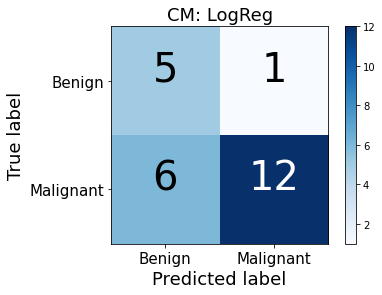

In [834]:

log_clf = LogisticRegression(**CV_log_clf.best_params_,
    random_state=RANDOM_STATE
)

log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)


plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: LogReg')

#y_score = log_clf.decision_function(X_test)
y_score = log_clf.predict_proba(X_test)[:,1]

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
roc_data.append((fpr, tpr, 'ROC: LogReg'))

m = get_metrics(cm)
m['classifier'] = 'LogReg'
m['scenario'] = 'tuned' # default, tuned, selection


results.append(m)
m

### Recursive Feature Elimination

{'accuracy': 0.7083333333333334,
 'precision': 0.8666666666666667,
 'recall': 0.7222222222222222,
 'f1score': 0.7878787878787877,
 'classifier': 'Logistic regression',
 'scenario': 'selection'}

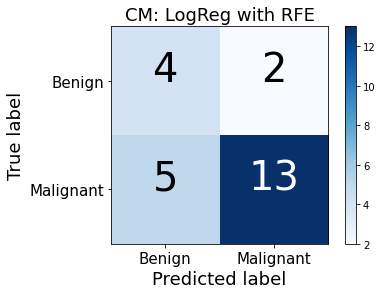

In [835]:
# there are 9 features in 2018-03-06 breast cancer data from UCI, let's select 4 of them
selector = RFE(log_clf, n_features_to_select=N_FEATURES_TO_SELECT)
selector = selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)
y_score = selector.predict_proba(X_test)[:,1]


# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: LogReg with RFE')

fpr, tpr, t = roc_curve(y_test, y_score)

#plot_roc(fpr, tpr, title='ROC: LogReg with RFE')
roc_data.append((fpr, tpr, 'ROC: LogReg with RFE'))

m = get_metrics(cm)
m['classifier'] = 'LogReg'
m['scenario'] = 'selection' # tuned, selection
results.append(m)
m

In [836]:
# support and ranking RFE
print(selector.support_)
print(selector.ranking_)
rfe_stats['LogReg'] = selector.ranking_


[False  True  True  True  True False False False False]
[4 1 1 1 1 6 5 2 3]


### Compare learning curves 

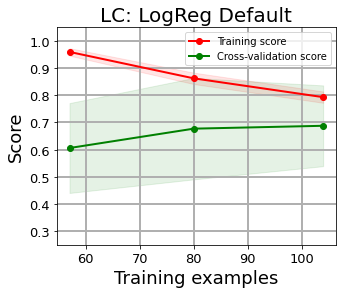

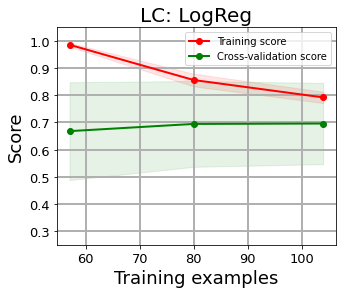

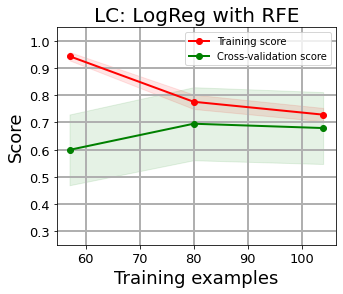

In [837]:
#Learning curve Log with best hyperpara
plot_learning_curve(log_clf_default, 'LC: LogReg Default')
plot_learning_curve(log_clf, 'LC: LogReg')

#Learning curve Log with RFE
plot_learning_curve(selector, 'LC: LogReg with RFE')

## Predictive Model: SVM(2)

### default

{'accuracy': 0.7916666666666666,
 'precision': 0.9333333333333333,
 'recall': 0.7777777777777778,
 'f1score': 0.8484848484848485,
 'classifier': 'SVM',
 'scenario': 'default'}

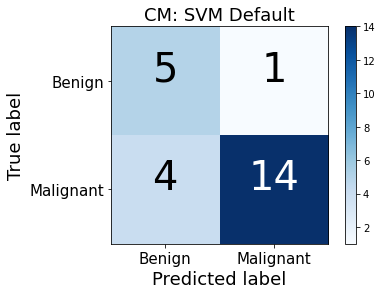

In [838]:
# Find best hyperparameters (accuracy)
from sklearn.svm import SVC
svm_clf_default = SVC(random_state = RANDOM_STATE)

svm_clf_default.fit(X_train, y_train)

y_pred = svm_clf_default.predict(X_test)
y_score = svm_clf_default.decision_function(X_test)
 
# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)


plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: SVM Default')
fpr, tpr, t = roc_curve(y_test, y_score)

#plot_roc(fpr, tpr, title='ROC: SVM Default')
roc_data.append((fpr, tpr, 'ROC: SVM Default'))

m = get_metrics(cm)
m['classifier'] = 'SVM'
m['scenario'] = 'default' # tuned, selection
results.append(m)
m

### Find best hyperparameters (accuracy)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
{'C': 1, 'kernel': 'linear'}


{'accuracy': 0.75,
 'precision': 0.9285714285714286,
 'recall': 0.7222222222222222,
 'f1score': 0.8125000000000001,
 'classifier': 'SVM',
 'scenario': 'tuned'}

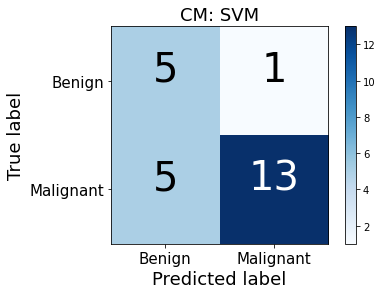

In [839]:

from sklearn.svm import SVC

param_grid = {
            'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],  
            'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
            }

CV_svm_clf = GridSearchCV(estimator = svm_clf_default, param_grid = param_grid , 
scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_svm_clf.fit(X_train, y_train)

print(CV_svm_clf.best_params_)
#SVM with best hyperparameter
svm_clf = SVC(C = CV_svm_clf.best_params_['C'], 
                                kernel = CV_svm_clf.best_params_['kernel'], 
                                random_state = RANDOM_STATE, probability=True)

svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
y_score = svm_clf.decision_function(X_test)
 
# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: SVM')
fpr, tpr, t = roc_curve(y_test, y_score)

#plot_roc(fpr, tpr, title='ROC: SVM')
roc_data.append((fpr, tpr, 'ROC: SVM'))

m = get_metrics(cm)
m['classifier'] = 'SVM'
m['scenario'] = 'tuned' # tuned, selection
results.append(m)
m

### Recursive Feature Elimination

{'accuracy': 0.75,
 'precision': 0.9285714285714286,
 'recall': 0.7222222222222222,
 'f1score': 0.8125000000000001,
 'classifier': 'SVM',
 'scenario': 'selected'}

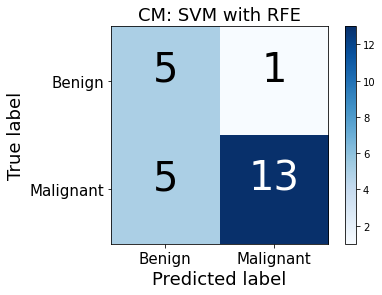

In [840]:

# there are 9 features in 2018-03-06 breast cancer data from UCI, let's select 4 of them
svm_as_selector = RFE(svm_clf, n_features_to_select=N_FEATURES_TO_SELECT)
svm_as_selector = svm_as_selector.fit(X_train, y_train)

y_pred = svm_as_selector.predict(X_test)
y_score = svm_as_selector.predict_proba(X_test)[:,1]


# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: SVM with RFE')

fpr, tpr, t = roc_curve(y_test, y_score)

#plot_roc(fpr, tpr, title='ROC: SVM with RFE')
roc_data.append((fpr, tpr, 'ROC: SVM with RFE'))

m = get_metrics(cm)
m['classifier'] = 'SVM'
m['scenario'] = 'selected' # tuned, selection
results.append(m)
m


### Comparing Curves & Cross Val scores

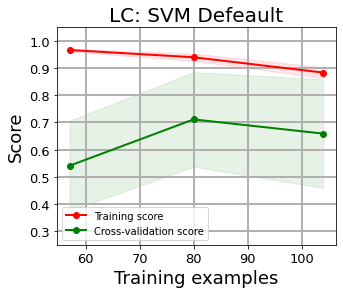

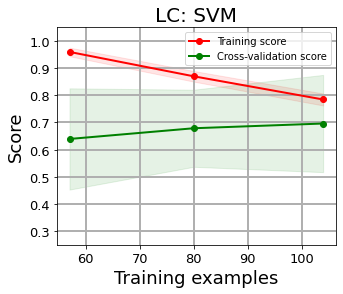

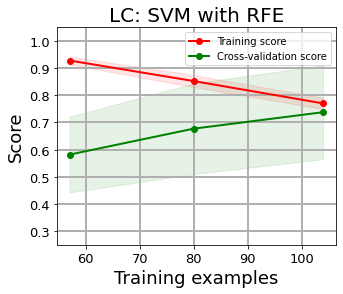

In [841]:
plot_learning_curve(svm_clf_default, 'LC: SVM Defeault')
plot_learning_curve(svm_clf, 'LC: SVM')
plot_learning_curve(svm_as_selector, 'LC: SVM with RFE')

## KNeighborsClassifier(3)

### Default

{'accuracy': 0.75,
 'precision': 0.9285714285714286,
 'recall': 0.7222222222222222,
 'f1score': 0.8125000000000001,
 'classifier': 'KNN',
 'scenario': 'default'}

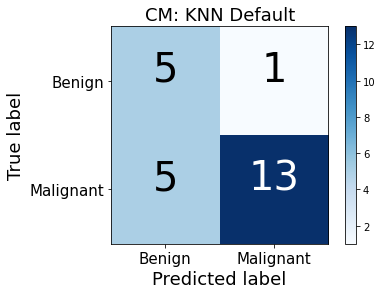

In [842]:
# Find best hyperparameters (accuracy)
from sklearn.neighbors import KNeighborsClassifier

knn_clf_default = KNeighborsClassifier()

knn_clf_default.fit(X_train, y_train)

y_pred = knn_clf_default.predict(X_test)
y_score = knn_clf_default.predict_proba(X_test)[:,1] # note probabilites for class 0 and 1 are returned in first and second columsn
#class 1 corresponds to positve (breast tomor case)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: KNN Default')

fpr, tpr, t = roc_curve(y_test, y_score)
#plot_roc(fpr, tpr, title='ROC: KNN Default')
roc_data.append((fpr, tpr, 'ROC: KNN Default'))

m = get_metrics(cm)
m['classifier'] = 'KNN'
m['scenario'] = 'default' # tuned, selection
results.append(m)
m

### KNN with best hyperparameters

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 6, 'weights': 'distance'}


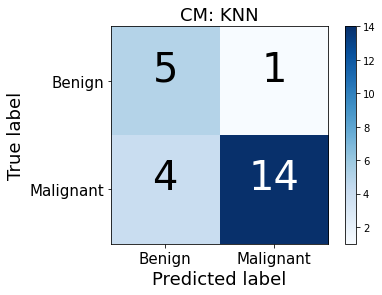

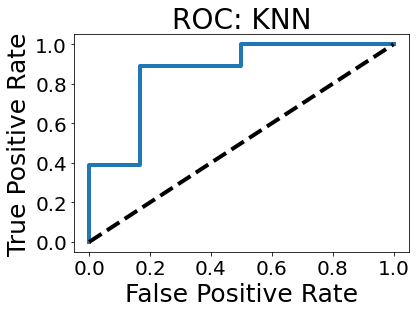

{'accuracy': 0.7916666666666666,
 'precision': 0.9333333333333333,
 'recall': 0.7777777777777778,
 'f1score': 0.8484848484848485,
 'classifier': 'KNN',
 'scenario': 'tuned'}

In [843]:
param_grid = {
    'n_neighbors':[1,2,3,4,5,6,7],
    'weights':['uniform','distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size':[10,20,30,40,50]
            }

CV_knn_clf = GridSearchCV(estimator = KNeighborsClassifier(), 
param_grid = param_grid , scoring = 'accuracy', 
                          verbose = 1, n_jobs = -1)
CV_knn_clf.fit(X_train, y_train)

print(CV_knn_clf.best_params_)

knn_clf = KNeighborsClassifier(**CV_knn_clf.best_params_)

knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)
y_score = knn_clf.predict_proba(X_test)[:,1] # note probabilites for class 0 and 1 are returned in first and second columsn
#class 1 corresponds to positve (breast tomor case)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: KNN')

fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc(fpr, tpr, title='ROC: KNN')
roc_data.append((fpr, tpr, 'ROC: KNN'))

m = get_metrics(cm)
m['classifier'] = 'KNN'
m['scenario'] = 'tuned' # tuned, selection
results.append(m)
m


### Recrusive feature elemenator

- not applicable - recursive feature elimination requires feature importances or coefficients for classifier/model, 
- but KNN is non-parameteric classifier

### Learning curve

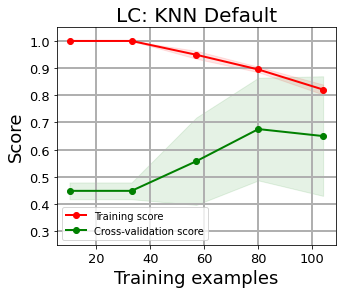

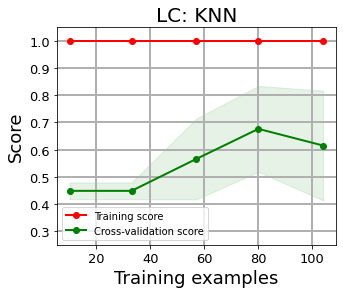

In [844]:

plot_learning_curve(knn_clf_default, 'LC: KNN Default')

plot_learning_curve(knn_clf, 'LC: KNN')


## Predictor Model: Gaussian Process(4)

### Default

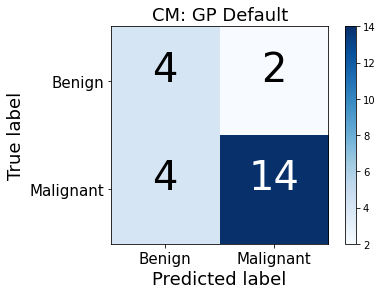

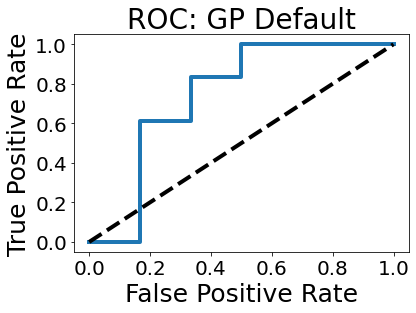

{'accuracy': 0.75,
 'precision': 0.875,
 'recall': 0.7777777777777778,
 'f1score': 0.823529411764706,
 'classifier': 'GP',
 'scenario': 'default'}

In [845]:
gp_clf_default = GaussianProcessClassifier(     
                                random_state = RANDOM_STATE)
gp_clf_default.fit(X_train, y_train)
y_pred = gp_clf_default.predict(X_test)
y_score = gp_clf_default.predict_proba(X_test)[:,1]
 
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: GP Default')

fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc(fpr, tpr, title='ROC: GP Default')
roc_data.append((fpr, tpr, 'ROC: GP Default'))

m = get_metrics(cm)
m['classifier'] = 'GP'
m['scenario'] = 'default' # tuned, selection
results.append(m)
m

### Gaussian Process and GridSearch CV to optimise hyperparameters (accuracy)`

{'kernel': 1**2 * RBF(length_scale=1)}


/home/juma/miniconda3/envs/cancer/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/juma/miniconda3/envs/cancer/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


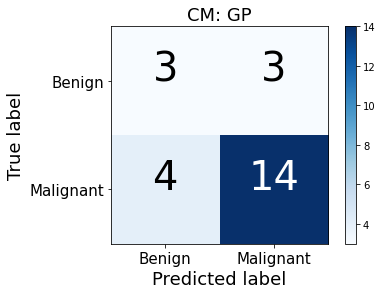

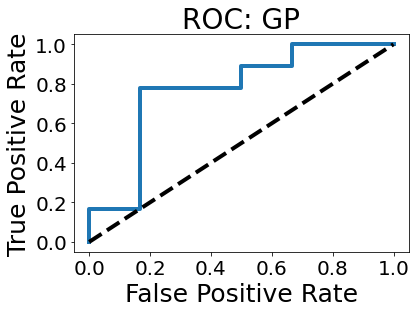

{'accuracy': 0.7083333333333334,
 'precision': 0.8235294117647058,
 'recall': 0.7777777777777778,
 'f1score': 0.7999999999999999,
 'classifier': 'GP',
 'scenario': 'tuned'}

In [846]:
from sklearn.gaussian_process import GaussianProcessClassifier
#define model
gp_clf = GaussianProcessClassifier()

param_grid = {'kernel':[1*RBF(), 1*DotProduct(), 1*Matern(),
1*RationalQuadratic(), 1*WhiteKernel()]}

search = GridSearchCV(gp_clf, param_grid, scoring='accuracy', cv=5, n_jobs=-1)
CV_gp_clf = search.fit(X_train, y_train)
print(CV_gp_clf.best_params_)

gp_clf = GaussianProcessClassifier(
    kernel = CV_gp_clf.best_params_['kernel'], 
                                random_state = RANDOM_STATE)
gp_clf.fit(X_train, y_train)
y_pred = gp_clf.predict(X_test)
y_score = gp_clf.predict_proba(X_test)[:,1]
 
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: GP')

fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc(fpr, tpr, title='ROC: GP')
roc_data.append((fpr, tpr, 'ROC: GP'))

m = get_metrics(cm)
m['classifier'] = 'GP'
m['scenario'] = 'tuned' # tuned, selection
results.append(m)
m


### Recursive Feature Elimination 
- not applicable - recursive feature elimination requires feature importances or coefficients for classifier/model, 
- because GaussianProcessClassifier is non-parameteric classifier

### Learning Curve

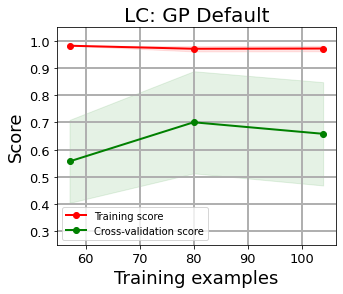

/home/juma/miniconda3/envs/cancer/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.



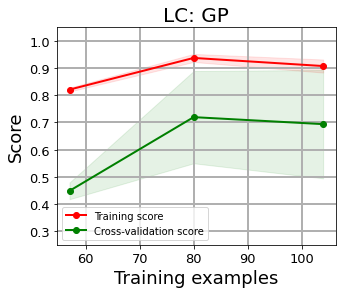

In [847]:
plot_learning_curve(gp_clf_default, 'LC: GP Default')
plot_learning_curve(gp_clf, 'LC: GP')


## Decision Tree(5)

### Default

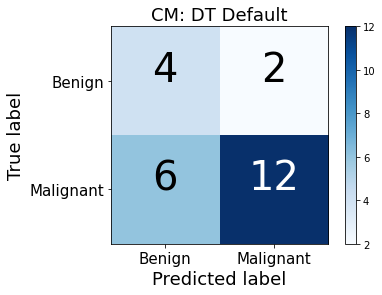

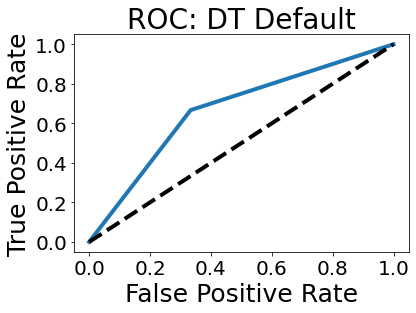

{'accuracy': 0.6666666666666666,
 'precision': 0.8571428571428571,
 'recall': 0.6666666666666666,
 'f1score': 0.75,
 'classifier': 'DT',
 'scenario': 'default'}

In [848]:
dt_clf_default = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_clf_default.fit(X_train, y_train)
y_pred = dt_clf_default.predict(X_test)
y_score = dt_clf_default.predict_proba(X_test)[:,1]

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)


plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: DT Default')

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc(fpr, tpr, title='ROC: DT Default')
roc_data.append((fpr, tpr, 'ROC: DT Default'))

m = get_metrics(cm)
m['classifier'] = 'DT'
m['scenario'] = 'default' # tuned, selection
results.append(m)
m

### Decision Tree and GridSearch CV to optimise hyperparameters (accuracy)`

Fitting 10 folds for each of 576 candidates, totalling 5760 fits
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 6}


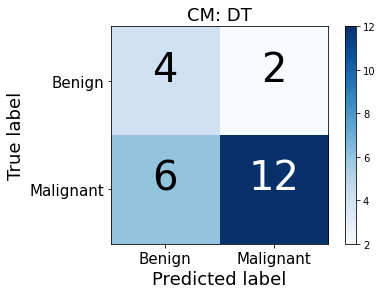

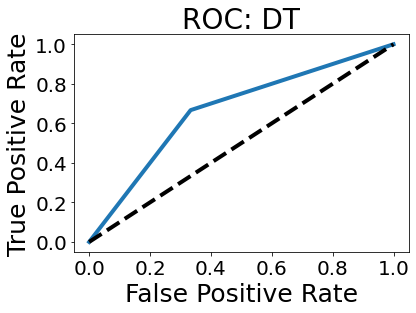

{'accuracy': 0.6666666666666666,
 'precision': 0.8571428571428571,
 'recall': 0.6666666666666666,
 'f1score': 0.75,
 'classifier': 'DT',
 'scenario': 'tuned'}

In [849]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "criterion":['gini','entropy'],
    "max_depth":range(1,10),
    "min_samples_split":range(2,10),
    "min_samples_leaf":range(1,5)
}

CV_dt_clf = GridSearchCV(dt_clf_default, param_grid=param_grid, verbose=1,cv=10, n_jobs=-1)
CV_dt_clf.fit(X_train, y_train)

print(CV_dt_clf.best_params_)

dt_clf = DecisionTreeClassifier(**CV_dt_clf.best_params_,
 random_state=RANDOM_STATE)

dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
y_score = dt_clf.predict_proba(X_test)[:,1]

# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)


plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: DT')

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc(fpr, tpr, title='ROC: DT')
roc_data.append((fpr, tpr, 'ROC: DT'))

m = get_metrics(cm)
m['classifier'] = 'DT'
m['scenario'] = 'tuned' # tuned, selection
results.append(m)
m

### Recursive Feature Elimination

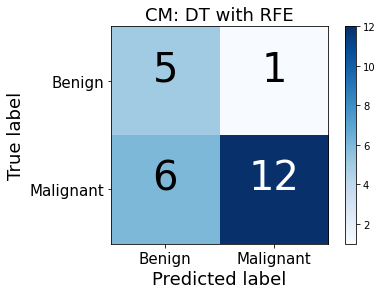

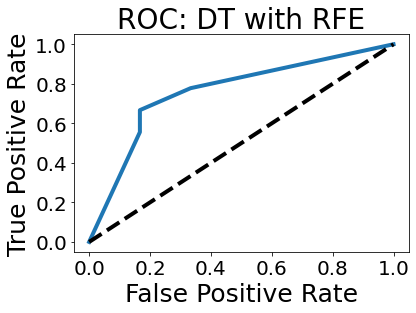

{'accuracy': 0.7083333333333334,
 'precision': 0.9230769230769231,
 'recall': 0.6666666666666666,
 'f1score': 0.7741935483870968,
 'classifier': 'DT',
 'scenario': 'selected'}

In [850]:

# there are 9 features in 2018-03-06 breast cancer data from UCI, let's select 4 of them
dt_selector = RFE(dt_clf, n_features_to_select=N_FEATURES_TO_SELECT)
dt_selector = dt_selector.fit(X_train, y_train)

y_pred = dt_selector.predict(X_test)
y_score = dt_selector.predict_proba(X_test)[:,1]


# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: DT with RFE')

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc(fpr, tpr, title='ROC: DT with RFE')
roc_data.append((fpr, tpr, 'ROC: DT with RFE'))

m = get_metrics(cm)
m['classifier'] = 'DT'
m['scenario'] = 'selected' # tuned, selection
results.append(m)
m


In [851]:
# support and ranking RFE
print(dt_selector.support_)
print(dt_selector.ranking_)
rfe_stats['DT'] = dt_selector.support_


[ True  True  True False False False False  True False]
[1 1 1 4 6 2 5 1 3]


### Learning curve 

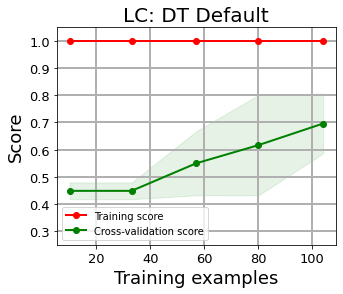

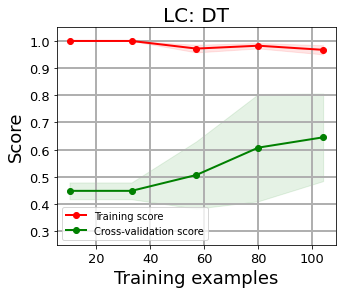

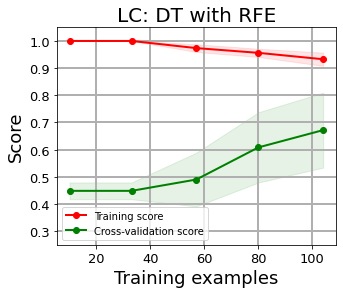

In [852]:
plot_learning_curve(dt_clf_default, 'LC: DT Default')
plot_learning_curve(dt_clf, 'LC: DT')
plot_learning_curve(dt_selector, 'LC: DT with RFE')


## Predictive model: Random Forest(7)

### Default

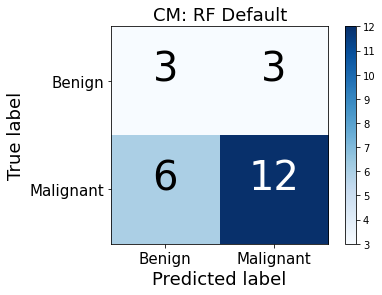

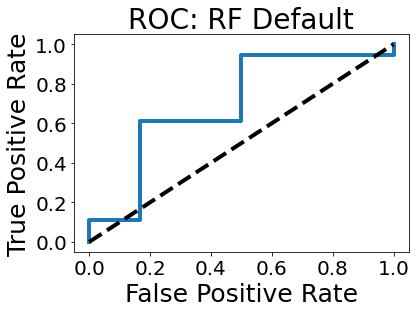

{'accuracy': 0.625,
 'precision': 0.8,
 'recall': 0.6666666666666666,
 'f1score': 0.7272727272727272,
 'classifier': 'RF',
 'scenario': 'default'}

In [853]:
rf_clf_default = RandomForestClassifier(random_state=RANDOM_STATE)
rf_clf_default = rf_clf_default.fit(X_train, y_train)

y_pred = rf_clf_default.predict(X_test)
y_score = rf_clf_default.predict_proba(X_test)[:,1]


# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: RF Default')

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc(fpr, tpr,'ROC: RF Default')
roc_data.append((fpr, tpr, 'ROC: RF Default'))

m = get_metrics(cm)
m['classifier'] = 'RF'
m['scenario'] = 'default' # tuned, selection
results.append(m)
m

### Random forest and GridSearch CV to optimise hyperparameters (accuracy)`

Fitting 10 folds for each of 150 candidates, totalling 1500 fits
{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 500}


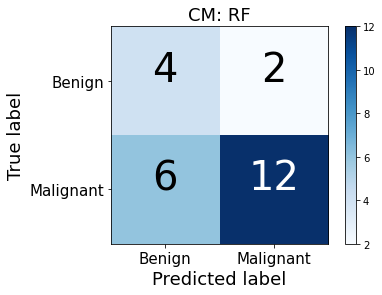

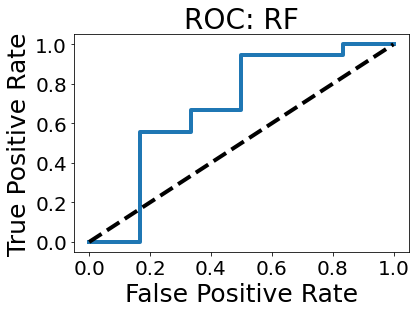

{'accuracy': 0.6666666666666666,
 'precision': 0.8571428571428571,
 'recall': 0.6666666666666666,
 'f1score': 0.75,
 'classifier': 'RF',
 'scenario': 'tuned'}

In [854]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

#cv = KFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)


param_grid = { 
    'n_estimators': [10, 50,100,500,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


CV_rf_clf = GridSearchCV(rf_clf_default, param_grid=param_grid,
 verbose=1,cv=10, n_jobs=-1)
CV_rf_clf.fit(X_train, y_train)

print(CV_rf_clf.best_params_)

rf_clf = RandomForestClassifier(**CV_rf_clf.best_params_, 
random_state=RANDOM_STATE)
rf_clf = rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)
y_score = rf_clf.predict_proba(X_test)[:,1]


# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: RF')

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc(fpr, tpr,'ROC: RF')
roc_data.append((fpr, tpr, 'ROC: RF'))

m = get_metrics(cm)
m['classifier'] = 'RF'
m['scenario'] = 'tuned' # tuned, selection
results.append(m)
m

### Recursive Feature Elimination

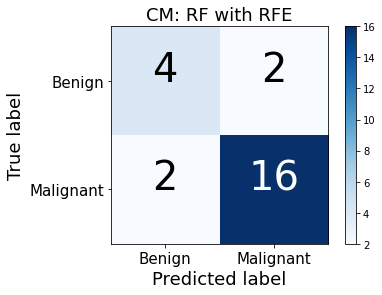

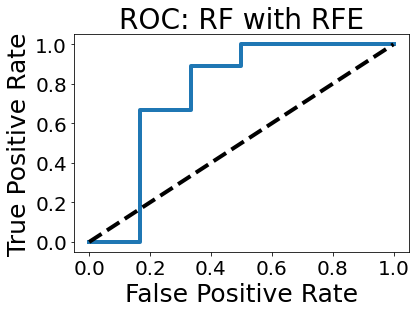

{'accuracy': 0.8333333333333334,
 'precision': 0.8888888888888888,
 'recall': 0.8888888888888888,
 'f1score': 0.8888888888888888,
 'classifier': 'RF',
 'scenario': 'selected'}

In [855]:

# there are 9 features in 2018-03-06 breast cancer data from UCI, let's select 4 of them
rf_selector = RFE(RandomForestClassifier(**CV_rf_clf.best_params_, 
random_state=RANDOM_STATE),
 n_features_to_select=N_FEATURES_TO_SELECT)

rf_selector = rf_selector.fit(X_train, y_train)

y_pred = rf_selector.predict(X_test)
y_score = rf_selector.predict_proba(X_test)[:,1]


# Confusion maxtrix & metrics
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, 
                      classes=CLASS_NAMES, 
                      title='CM: RF with RFE')

# ROC curve
fpr, tpr, t = roc_curve(y_test, y_score)
plot_roc(fpr, tpr,'ROC: RF with RFE')
roc_data.append((fpr, tpr, 'ROC: RF with RFE'))

m = get_metrics(cm)
m['classifier'] = 'RF'
m['scenario'] = 'selected' # tuned, selection
results.append(m)
m


### Learning curve 

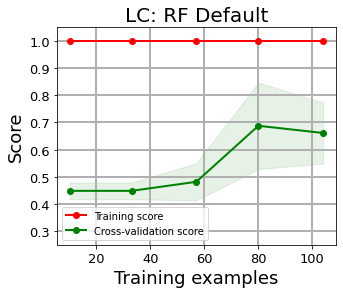

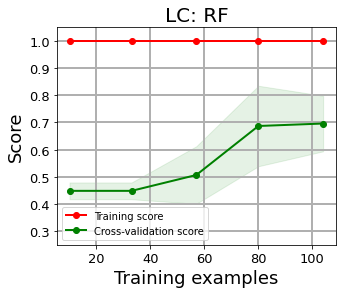

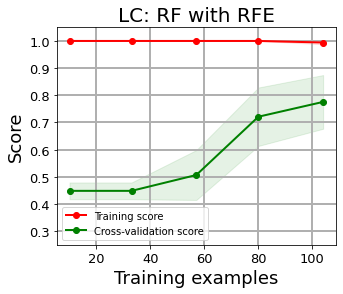

In [857]:
plot_learning_curve(rf_clf_default, 'LC: RF Default')
plot_learning_curve(rf_clf, 'LC: RF')
plot_learning_curve(rf_selector, 'LC: RF with RFE')


In [860]:
df = pd.DataFrame(results)
df.set_index(['classifier','scenario']).to_csv('experiment/sensitivity.csv')

## Plot ROC for all

In [862]:
len(roc_data)

16

In [864]:
roc_data[0]

(array([0.        , 0.        , 0.        , 0.16666667, 0.16666667,
        0.66666667, 0.66666667, 1.        , 1.        ]),
 array([0.        , 0.05555556, 0.5       , 0.5       , 0.83333333,
        0.83333333, 0.88888889, 0.88888889, 1.        ]),
 'ROC: LogReg Default')

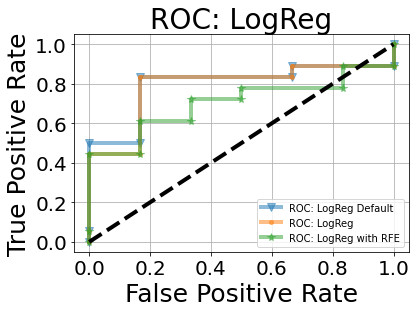

In [905]:
plot_roc_comparison(roc_data[:3], title='ROC: LogReg')

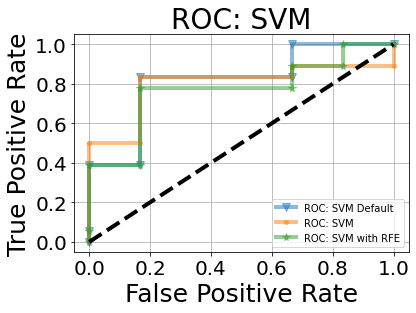

In [904]:
plot_roc_comparison(roc_data[3:6], title='ROC: SVM')

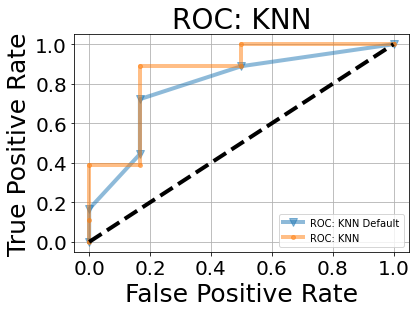

In [903]:
plot_roc_comparison(roc_data[6:8], title='ROC: KNN')

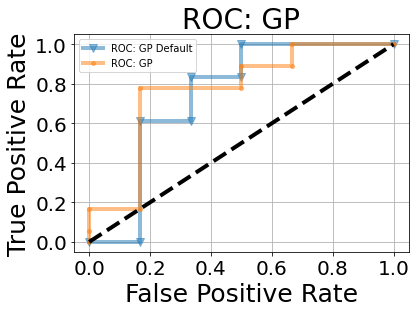

In [902]:
plot_roc_comparison(roc_data[8:10], title='ROC: GP')

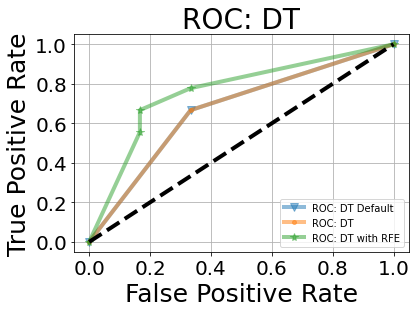

In [901]:
plot_roc_comparison(roc_data[10:13], title='ROC: DT')

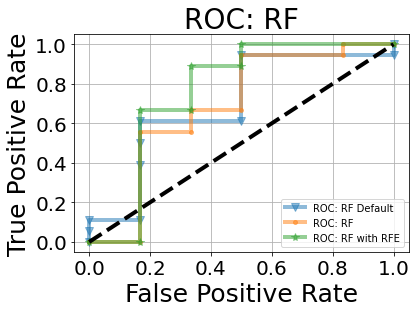

In [900]:
plot_roc_comparison(roc_data[13:], title='ROC: RF')